In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import pickle
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [16]:
with open('data/company_embeddings/embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

df = pd.read_csv('data/terms_of_service.csv')

In [17]:
valid_companies = []
embedding_matrix = []
categories = []

In [18]:
for _, row in df.iterrows():
    filename = f"{row['Company'].lower().replace(' ', '')}.txt"
    if filename in embeddings:
        valid_companies.append(row['Company'])
        embedding_matrix.append(embeddings[filename])
        categories.append(row['Category'])

In [19]:
embedding_matrix = np.array(embedding_matrix)
similarity_matrix = cosine_similarity(embedding_matrix)

similarity_df = pd.DataFrame(similarity_matrix, 
                            index=valid_companies, 
                            columns=valid_companies)

## Simmilarity Within-Category vs Between-Category

In [20]:
within_category = []
between_category = []

n = len(valid_companies)
for i in range(n):
    for j in range(i+1, n):
        if categories[i] == categories[j]:
            within_category.append(similarity_matrix[i,j])
        else:
            between_category.append(similarity_matrix[i,j])

C:\Users\kaszt\AppData\Local\Temp\ipykernel_9744\3435450819.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(within_category, label='Within Category', shade=True)
C:\Users\kaszt\AppData\Local\Temp\ipykernel_9744\3435450819.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(between_category, label='Between Categories', shade=True)


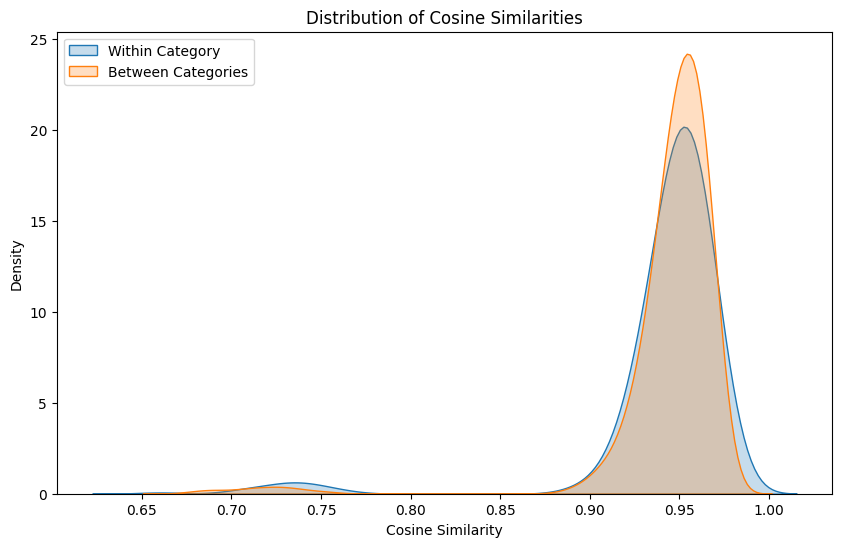

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(within_category, label='Within Category', shade=True)
sns.kdeplot(between_category, label='Between Categories', shade=True)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.legend()
plt.show()

In [22]:
print("Mean within category similarity:", np.mean(within_category))
print("Mean between category similarity:", np.mean(between_category))

Mean within category similarity: 0.941868
Mean between category similarity: 0.94415534


In [23]:
# ANOVA test (parametric)
f_val, p_val = f_oneway(within_category, between_category)
print(f"\nANOVA results: F={f_val:.3f}, p={p_val:.4f}")


ANOVA results: F=1.404, p=0.2361


In [24]:
# Kruskal-Wallis test (non-parametric)
h_val, p_val = kruskal(within_category, between_category)
print(f"Kruskal-Wallis results: H={h_val:.3f}, p={p_val:.4f}")

Kruskal-Wallis results: H=0.213, p=0.6444


There is no statistically significant difference between the mean similarity scores of:
 - Companies within the same category (0.941868)
 - Companies from different categories (0.944155)

Null hypothesis (H₀) = "Mean similarities are equal across groups" cannot be rejected.

## Category-Level Analysis

In [25]:
category_pairs = []
similarities = []

In [26]:
for i in range(n):
    for j in range(i+1, n):
        pair = tuple(sorted((categories[i], categories[j])))
        category_pairs.append(pair)
        similarities.append(similarity_matrix[i,j])

In [27]:
category_df = pd.DataFrame({
    'Category Pair': category_pairs,
    'Similarity': similarities
})
category_df['Same Category'] = category_df['Category Pair'].apply(lambda x: x[0] == x[1])

In [28]:
melted_data = []
for i in range(n):
    for j in range(i+1, n):
        melted_data.append({
            'Category1': categories[i],
            'Category2': categories[j],
            'Similarity': similarity_matrix[i,j]
        })

melted_df = pd.DataFrame(melted_data)
same_category = melted_df[melted_df['Category1'] == melted_df['Category2']]
same_category['Comparison'] = same_category['Category1']
diff_category = melted_df[melted_df['Category1'] != melted_df['Category2']]
diff_category['Comparison'] = "Different Categories"

C:\Users\kaszt\AppData\Local\Temp\ipykernel_9744\2995635593.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_category['Comparison'] = same_category['Category1']
C:\Users\kaszt\AppData\Local\Temp\ipykernel_9744\2995635593.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_category['Comparison'] = "Different Categories"


In [29]:
tukey_data = pd.concat([same_category, diff_category])

tukey_results = pairwise_tukeyhsd(
    endog=tukey_data['Similarity'],
    groups=tukey_data['Comparison'],
    alpha=0.05
)

print(tukey_results)

                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                         group2              meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------------
                    Analytics          Artificial Intelligence   -0.013 0.9967 -0.0629   0.037  False
                    Analytics     Collaboration & Productivity  -0.0317 0.5537 -0.0814  0.0179  False
                    Analytics    Cybersecurity & IT Management  -0.0068    1.0 -0.0755  0.0619  False
                    Analytics             Design & Development  -0.0146  0.994 -0.0663   0.037  False
                    Analytics             Different Categories  -0.0151 0.9892 -0.0637  0.0336  False
                    Analytics          Human Resources & Legal  -0.0194 0.9709 -0.0729  0.0341  False
                    Analytics                Marketing & Sales  -0.0097 0.9996 -0.

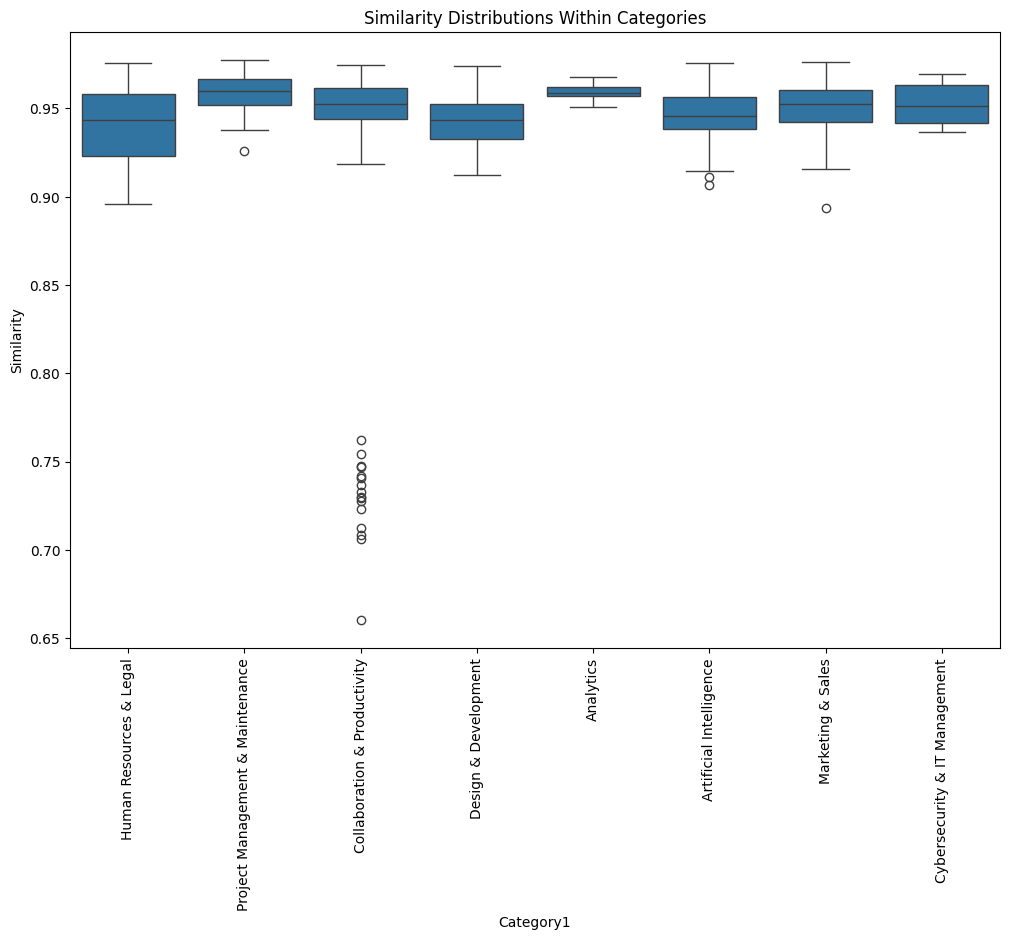

In [32]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=same_category, x='Category1', y='Similarity')
plt.title('Similarity Distributions Within Categories')
plt.xticks(rotation=90)
plt.show()

## Employee Size Analysis

In [35]:
company_data = []
for _, row in df.iterrows():
    filename = f"{row['Company'].lower().replace(' ', '')}.txt"
    if filename in embeddings:
        company_data.append({
            'Company': row['Company'],
            'Category': row['Category'],
            'Employees': row['Employees']
        })

employee_df = pd.DataFrame(company_data)

employee_df['MeanSimilarity'] = np.mean(similarity_matrix, axis=1)

In [36]:
groups = [employee_df[employee_df['Employees'] == size]['MeanSimilarity'] 
          for size in employee_df['Employees'].unique()]

h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {p_val:.4f}")

if p_val < 0.05:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(
        endog=employee_df['MeanSimilarity'],
        groups=employee_df['Employees'],
        alpha=0.05
    )
    print(tukey.summary())

Kruskal-Wallis p-value: 0.9033


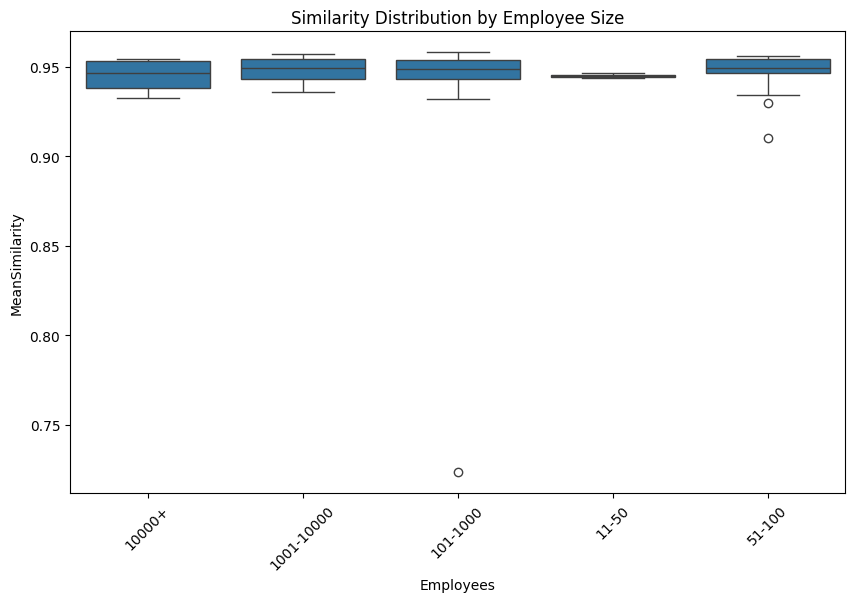

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=employee_df, x='Employees', y='MeanSimilarity', order=sorted(employee_df['Employees'].unique()))
plt.title("Similarity Distribution by Employee Size")
plt.xticks(rotation=45)
plt.show()

C:\Users\kaszt\AppData\Local\Temp\ipykernel_9744\870036346.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=employee_df, x='Employees', y='MeanSimilarity', hue='Category', ci='sd')


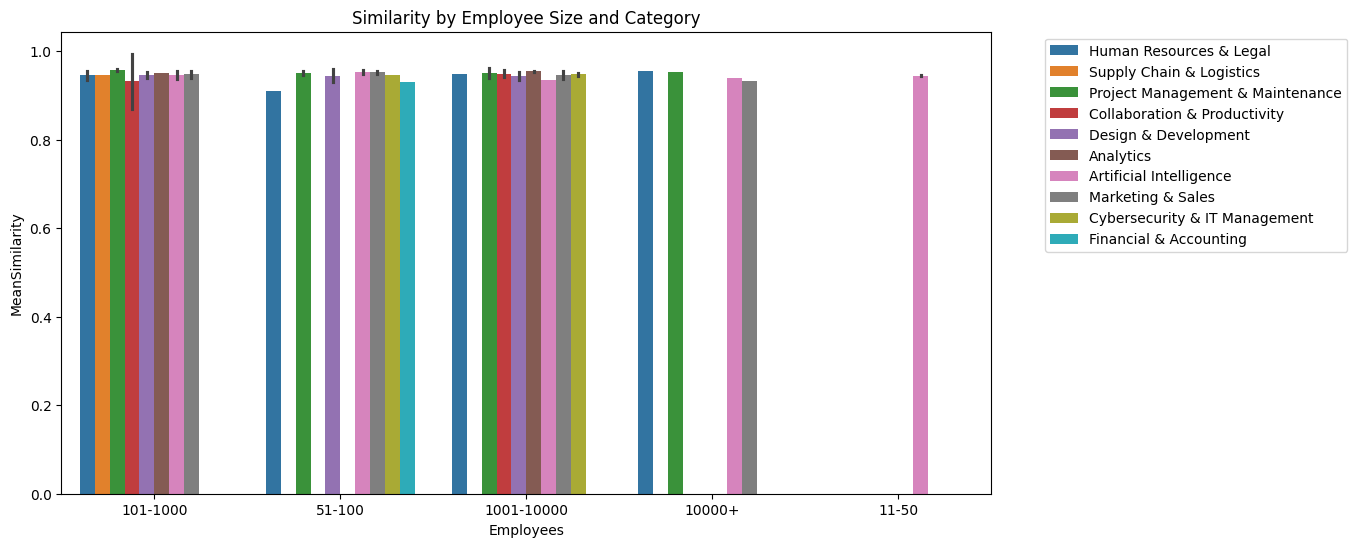

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(data=employee_df, x='Employees', y='MeanSimilarity', hue='Category', ci='sd')
plt.title("Similarity by Employee Size and Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()